## Tie-breaking rules

In [1]:
# p/q/r: share of +1 / -1 / 0 when the set of grades is +1/-1/0
def gauge(vec):
    p, r, q = vec
    if p > 0.5: 
        g = 1
        q = 1-p
        p = 0
    elif q>0.5: 
        g = -1
        p = 1-q
        q = 0
    else: g = 0 
    return((g, p, q))

# The tie-breaking rule corresponds to p, q < 0.5
def mj(vec):
#     p, r, q = vec
#     g=0
    g, p, q = gauge(vec)
    if p > 0.5: return(p)
    elif q>0.5: return(-q)
    else: return(g+(p>q)*p - (p<=q)*q)

def Delta(vec): # = vote par notes
#     p, r, q = vec
#     g=0
    g, p, q = gauge(vec)
    if p > 0.5: return(p)
    elif q>0.5: return(-q)
    else: return(g+p-q)

def sigma(vec):
#     p, r, q = vec
#     g = 0
    g, p, q = gauge(vec)
#     try:  
#         if p > 0.5: score = 1/4 + p/2 # 1 + (0 + p-1 - 1/2)/2
#         elif q>0.5: score =-1/4 - q/2 # 1 + (1 + 1-q - 1/2)/2
#         else: score = (p/(p+q) + (p*q==0)*(p-q) - 1/2)/2
#     except ZeroDivisionError:
#         score = 0
#     return(score)
    return(g + (p*q!=0 or g==0)*0.5*(p-q)/(p+q)**(p+q!=0) + (p*q==0 and g!=0)*(p-q))

# TODO: definition sigma on the edges need it really to be special? why can't we take 2*sigma and same definitions as the others for p,q>0.5?
def normalized_Delta(vec):
#     p, r, q = vec
#     g=0
    g, p, q = gauge(vec)
#     if p > 0.5: 
#         g = 1
#         q = 1-p
#         p = 0
#     elif q>0.5: 
#         g = -1
#         p = 1-q
#         q = 0
#     else: g = 0 vec
    return(g + 0.5*(p-q)/(1-p-q)**(p+q!=1))
#     return((p*(q<0.5)-q*(p<0.5))/((2*r)**(max(p,q)<0.5)))

def average(vec):
#     p, r, q = vec
#     g=0
    g, p, q = gauge(vec)
    return(g+p-q)

In [2]:
import plotly.graph_objs as go
import plotly.io as pio
import numpy as np
from ternary.helpers import normalize, simplex_iterator
import matplotlib
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

## Contour Map with Plotly

In [3]:
# TODO: separate data from layout to be able to change rapidly the vertex_text, color A, B and C in function of their rank
def ternary_rules(mesh = 150, colorscale = 'gnuplot2', vertex_text = ['$0$', '$-1$', '$+1$'], grid=4, 
                  restr=True, mean=False, save = 'ternary plots/contours3.png', n=True, rhombus = True, invAB=False): 
    # vertex can be ['$0$', '$-1$', '$+1$'] ['M', 'L', 'H'] ['$r$', '$q$', '$p$']
    # colorscale can be gnuplot2 viridis RdYlGn jet RdYlGn
    offset = 1.2
    def tern2cart(coord):
        q, r, p = tuple(coord)
        return(((2*p + r)/(2*(q+p+r)), 3**0.5*r/(2*(q+p+r))))
    fontsize, v_fontsize = 100, 12
    ternary_layout = dict(title='', width=1080+(mean+n)*220, height=280-30*(mean+n), margin=dict(l=0, r=0, b=0, t=0),
                    xaxis=dict(visible=False, title='', ticks='', showgrid=False, showticklabels=False, zeroline=False), 
                    yaxis=dict(visible=False, range=[-0.12, 0.92]), plot_bgcolor='rgb(255,255,255)', showlegend=True, annotations=[dict(showarrow=False, # height=525
                        text=vertex_text[0], x=0.5, y=np.sqrt(3)/2, align='center', xanchor='center', yanchor='bottom', font=dict(size=v_fontsize)),
                        dict(showarrow=False, text=vertex_text[1], x=0, y=0, align='left',xanchor='right', yanchor='top', font=dict(size=v_fontsize)),
                        dict(showarrow=False, text=vertex_text[2], x=1, y=0, align='right', xanchor='left', yanchor='top', font=dict(size=v_fontsize)),
                    dict(showarrow=False, text='$mj$', x=offset/2-0.08, y=-0.03, align='left',xanchor='right', yanchor='top', font=dict(size=fontsize)),
        dict(showarrow=False, text=vertex_text[0], x=offset+0.5, y=np.sqrt(3)/2, align='center', xanchor='center', yanchor='bottom', font=dict(size=v_fontsize)),
                        dict(showarrow=False, text=vertex_text[1], x=offset, y=0, align='left',xanchor='right', yanchor='top', font=dict(size=v_fontsize)),
                        dict(showarrow=False, text=vertex_text[2], x=offset+1, y=0, align='right', xanchor='left', yanchor='top', font=dict(size=v_fontsize)),
                    dict(showarrow=False, text='$d$', x=1.5*offset-0.1+0.03, y=-0.03, align='left',xanchor='right', yanchor='top', font=dict(size=fontsize)), # $\Delta$
        dict(showarrow=False, text=vertex_text[0], x=2*offset+0.5, y=np.sqrt(3)/2, align='center', xanchor='center', yanchor='bottom', font=dict(size=v_fontsize)),
                        dict(showarrow=False, text=vertex_text[1], x=2*offset, y=0, align='left',xanchor='right', yanchor='top', font=dict(size=v_fontsize)),
                        dict(showarrow=False, text=vertex_text[2], x=2*offset+1, y=0, align='right', xanchor='left', yanchor='top', font=dict(size=v_fontsize)),
                    dict(showarrow=False, text='$s$', x=2.5*offset-0.07, y=-0.05, align='left',xanchor='right', yanchor='top', font=dict(size=fontsize))], # $\sigma$
                         legend = {'x': 0.90, 'y':0.95})
    cmap = matplotlib.cm.get_cmap(colorscale)
    pl_entries = 255
    h = 1.0/(255-1)
    pl_colorscale = []
    for k in range(255):
        C = np.uint8(np.array(cmap(k*h)[:3])*255)
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
    
    data = []
    shift = 0
    if invAB:
        xA, yA = tern2cart([0.1, 0.6, 0.3]) 
        xB, yB = tern2cart([0.01, 0.85, 0.11]) 
    else:
        xA, yA = tern2cart([0.01, 0.85, 0.11]) # 0.1, 0.88, 0.11
        xB, yB = tern2cart([0.1, 0.6, 0.3]) # 0.2, 0.4, 0.4
    xC, yC = tern2cart([0.27, 0.33, 0.4]) # 0.27, 0.3, 0.43
    xD, yD = tern2cart([0.43, 0.12, 0.45]) # was C
    if mean: list_func = [mj, Delta, sigma, average]
    elif n: list_func = [mj, Delta, sigma, normalized_Delta]
    else: list_func = [mj, Delta, sigma]
    for func in list_func:
        show = shift==0
        z, gr_x, gr_y = [], [], []
        for i, j, k in simplex_iterator(scale=mesh, boundary=True):
            z += [func(normalize([i, j, k]))]
            xy = tern2cart([i, j, k])
            gr_x += [xy[0]]
            gr_y += [xy[1]]
        z, gr_x, gr_y = np.array(z)*2**(restr*(func==sigma)), np.array(gr_x), np.array(gr_y) # 
        grid_x, grid_y = np.meshgrid(gr_x, gr_y)
        data.append(dict(type='contour', x=gr_x+shift, y=gr_y, z=-z, text=None, hoverinfo='text', colorscale=pl_colorscale, reversescale=False, ncontours = 15,
                         contours={'coloring': 'heatmap'}, zmin= -1+0.5*restr, zmax=1-0.5*restr,
            line=dict(width=1.2, color='rgb(255,255,255)'), showlegend=False, colorbar=dict(x = 0.98, thickness=20, ticklen=4, tickfont={'size':v_fontsize}))) # 0.5
        data.append(dict(type='scatter', x=np.array([0, 0, 0.5, 0])+shift, y=[0, np.sqrt(3)/2, np.sqrt(3)/2, 0], 
                      fill = 'toself', line = dict(color='#ffffff'), fillcolor = '#ffffff', showlegend=False))
        data.append(dict(type='scatter', x=np.array([1, 1, 0.5, 1])+shift, y=[0, np.sqrt(3)/2, np.sqrt(3)/2, 0], 
                          fill = 'toself', line = dict(color='#ffffff'), fillcolor = '#ffffff', showlegend=False))
        if n: 
            ternary_layout['annotations'].append(
                dict(showarrow=False, text=vertex_text[0], x=3*offset+0.5, y=np.sqrt(3)/2, align='center', xanchor='center', yanchor='bottom', font=dict(size=v_fontsize)))
            ternary_layout['annotations'].append(
                dict(showarrow=False, text=vertex_text[1], x=3*offset, y=0, align='left',xanchor='right', yanchor='top', font=dict(size=v_fontsize)))
            ternary_layout['annotations'].append(
                dict(showarrow=False, text=vertex_text[2], x=3*offset+1, y=0, align='right', xanchor='left', yanchor='top', font=dict(size=v_fontsize)))
            ternary_layout['annotations'].append(
                dict(showarrow=False, text='$n$', x=3.5*offset-0.07, y=-0.05, align='left',xanchor='right', yanchor='top', font=dict(size=fontsize))) # $\\nu$
            name_mj = 'D'
        else: name_mj = 'C'
        if restr:
            data.append(dict(type='scatter', x=np.array([0, 0.5, 0.25, 0])+shift, y=[0, 0, np.sqrt(3)/4, 0], 
                          fill = 'toself', line = dict(color='#ffffff'), fillcolor = '#ffffff', showlegend=False))
            data.append(dict(type='scatter', x=np.array([0, 0.5, 0.25, 0])+shift+0.5, y=[0, 0, np.sqrt(3)/4, 0], 
                          fill = 'toself', line = dict(color='#ffffff'), fillcolor = '#ffffff', showlegend=False))    
        if grid is not None and grid > 0:
            ticks = [k/grid for k in range(1, grid)]
            ticks_q = [tern2cart([0, 1-p, p]) for p in ticks]
            ticks_r = [tern2cart([q, 0, 1-q]) for q in ticks]
            ticks_p = [tern2cart([1-r, r, 0]) for r in ticks]
            for i in range(grid-1):
                data.append(dict(type='scatter', x=np.array([ticks_q[i][0], ticks_p[grid-2-i][0]])+shift, y=[ticks_q[i][1], ticks_p[grid-2-i][1]], 
                                mode='lines', line=dict(width=0.3, color='#666'), hoverinfo='none', showlegend=False))
                data.append(dict(type='scatter', x=np.array([ticks_r[i][0], ticks_q[grid-2-i][0]])+shift, y=[ticks_r[i][1], ticks_q[grid-2-i][1]], 
                                mode='lines', line=dict(width=0.3, color='#666'), hoverinfo='none', showlegend=False))
                data.append(dict(type='scatter', x=np.array([ticks_p[i][0], ticks_r[grid-2-i][0]])+shift, y=[ticks_p[i][1], ticks_r[grid-2-i][1]], 
                                mode='lines', line=dict(width=0.3, color='#666'), hoverinfo='none', showlegend=False))    
        data.append(dict(type='scatter', x=np.array([0.5, 0, 1, 0.5])+shift, y=[np.sqrt(3)/2, 0, 0, np.sqrt(3)/2], mode='lines', #fill = 'tonext',
                      line=dict(width=1, color='#444444'), hoverinfo='none', showlegend=False))       
        if rhombus:    
            data.append(dict(type='scatter', x=[xA+shift], y=[-1], name='p, q ≤ 1/2',  mode='markers', # ½
                             showlegend=show, marker={'symbol': 'diamond-tall', 'color': '#fff', 'size':10, 'line': {'color': '#f00', 'width': 1.5}})) # 1.5
            for x1 in [0.25, 0.75]:
                for y0 in [0, 1]:
                    data.append(dict(type='scatter', x=np.array([0.5, x1])+shift, y=(3**0.5/2)*np.array([y0, 0.5]), 
                             mode='lines', line=dict(width=2.8, color='#f00'), hoverinfo='none', showlegend=False))           # 1.7
        data.append(dict(type='scatter', x=[xA+shift], y=[yA], name='A',  mode='markers', showlegend=show, marker={'symbol': 'star-triangle-up', 'color': '#000', 'size':8}))
        data.append(dict(type='scatter',x=[xB+shift],y=[yB],name='B',mode='markers',showlegend=show,marker={'symbol':'circle','color': '#000','size':8}))
        if n: data.append(dict(type='scatter', x=[xC+shift], y=[yC], name='C',  mode='markers', showlegend=show, marker={'symbol': 'square', 'color': '#000', 'size':7})) 
        data.append(dict(type='scatter', x=[xD+shift], y=[yD], name=name_mj, mode='markers', showlegend=show, 
                         marker={'symbol': 'x-thin', 'size':8, 'line': {'width': 2, 'color': '#000'}}))   
        shift += offset
    ternary_layout.update()
    fw1 = go.FigureWidget(data=data, layout=ternary_layout) # tick_trace, 
#     iplot(fw1)
    if save: pio.write_image(fw1, save)
    return(fw1)

In [4]:
ternary_rules(150, save='ternary plots/all_rhombus_big.png', restr=False, invAB=True)

FigureWidget({
    'data': [{'colorbar': {'thickness': 20, 'tickfont': {'size': 12}, 'ticklen': 4, 'x': 0.98},…

In [ ]:
ternary_rules(150, save='ternary plots/all_rhombus_big.png', restr=False)

In [5]:
ternary_rules(150, save='ternary plots/all_rhombusInvAB.png', restr=False, invAB=True)

FigureWidget({
    'data': [{'colorbar': {'thickness': 20, 'tickfont': {'size': 12}, 'ticklen': 4, 'x': 0.98},…

In [5]:
ternary_rules(150, n=False, restr=False)

FigureWidget({
    'data': [{'colorbar': {'thickness': 20, 'tickfont': {'size': 12}, 'ticklen': 4, 'x': 0.98},…

In [93]:
ternary_rules(30, save=False)

FigureWidget({
    'data': [{'colorbar': {'thickness': 20, 'tickfont': {'size': 12}, 'ticklen': 4, 'x': 0.98},…

In [142]:
ternary_rules(30, save=False, n=False)

FigureWidget({
    'data': [{'colorbar': {'thickness': 20, 'tickfont': {'size': 12}, 'ticklen': 4, 'x': 0.98},…

In [110]:
ternary_rules(30, save=False, restr=False, mean=True, n=False)

FigureWidget({
    'data': [{'colorbar': {'thickness': 20, 'tickfont': {'size': 12}, 'ticklen': 4, 'x': 0.98},…

In [56]:
fig = ternary_rules()

In [76]:
# Single plot
def ternary_rule(func = mj, colorscale = 'gnuplot2', vertex_text = ['$0$', '$-1$', '$+1$'], mesh = 4): 
    # vertex can be ['$0$', '$-1$', '$+1$'] ['M', 'L', 'H'] ['$r$', '$q$', '$p$']
    # colorscale can be gnuplot2 viridis RdYlGn jet 
    def tern2cart(coord):
        x, z, y = tuple(coord)
        return(((2*y + z)/(2*(x+y+z)), 3**0.5*z/(2*(x+y+z))))
    lfontsize, v_fontsize = 14, 14
    if func==mj: rule = '$mj$'
    elif func==Delta: rule = '$\Delta$'
    elif func==sigma: rule = '$\sigma$'
    else: rule='name?'
    ternary_layout = dict(title=rule, font=dict(family='Balto, sans-serif', size=14), width=550, height=550, 
                    xaxis=dict(visible=True, title=rule, ticks='', showgrid=False, showticklabels=False, zeroline=False), 
                    yaxis=dict(visible=False), plot_bgcolor='rgb(255,255,255)', showlegend=False, annotations=[dict(showarrow=False, # height=525
                        text=vertex_text[0], x=0.5, y=np.sqrt(3)/2, align='center', xanchor='center', yanchor='bottom', font=dict(size=v_fontsize)),
                        dict(showarrow=False, text=vertex_text[1], x=0, y=0, align='left',xanchor='right', yanchor='top', font=dict(size=v_fontsize)),
                        dict(showarrow=False, text=vertex_text[2], x=1, y=0, align='right', xanchor='left', yanchor='top', font=dict(size=v_fontsize))])
    cmap = matplotlib.cm.get_cmap(colorscale)
    pl_entries = 255
    h = 1.0/(255-1)
    pl_colorscale = []
    for k in range(255):
        C = np.uint8(np.array(cmap((254-k)*h)[:3])*255)
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    z, gr_x, gr_y = [], [], []
    for i, j, k in simplex_iterator(scale=mesh, boundary=True):
        z += [-func(normalize([i, j, k]))]
        xy = tern2cart([i, j, k])
        gr_x += [xy[0]]
        gr_y += [xy[1]]
    z, gr_x, gr_y = np.array(z), np.array(gr_x), np.array(gr_y)
    grid_x, grid_y = np.meshgrid(gr_x, gr_y)
    c_trace = dict(type='contour', x=gr_x, y=gr_y, z=z, text=None, hoverinfo='text', 
                     colorscale=pl_colorscale, reversescale=True, line=dict(width=0.5, color='rgb(255,255,255)'), colorbar=dict(thickness=20, ticklen=4))
    side_trace = dict(type='scatter', x=np.array([0.5, 0, 1, 0.5]), y=[np.sqrt(3)/2, 0, 0, np.sqrt(3)/2], mode='lines', #fill = 'tonext',
                      line=dict(width=2, color='#444444'), hoverinfo='none')
    blank0 = dict(type='scatter', x=np.array([0, 0, 0.5, 0]), y=[0, np.sqrt(3)/2, np.sqrt(3)/2, 0], 
                  fill = 'toself', line = dict(color='#ffffff'), fillcolor = '#ffffff')
    blank1 = dict(type='scatter', x=np.array([1, 1, 0.5, 1]), y=[0, np.sqrt(3)/2, np.sqrt(3)/2, 0], 
                  fill = 'toself', line = dict(color='#ffffff'), fillcolor = '#ffffff')
    fw1 = go.FigureWidget(data=[c_trace, blank0, blank1, side_trace], layout=ternary_layout) # tick_trace, 
    return(fw1)

# ternary_rule(Delta)

In [83]:
ternary_rule(normalized_Delta, mesh=30)

FigureWidget({
    'data': [{'colorbar': {'thickness': 20, 'ticklen': 4},
              'colorscale': [[0.0, '…

## Heatmap with Ternary

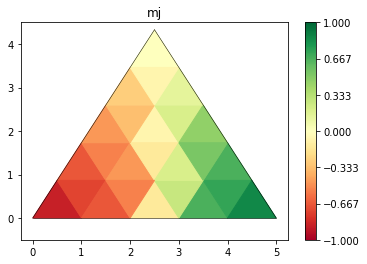

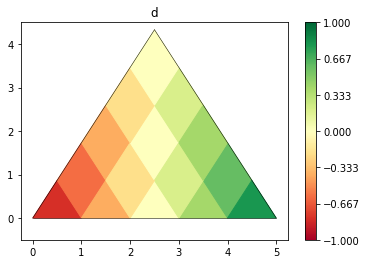

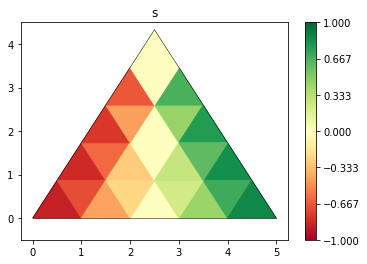

In [8]:
import ternary
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker

scale = 5

figure, MJ = ternary.figure(scale=scale)
MJ.heatmapf(mj, boundary=True, style="triangular", cmap = 'RdYlGn')
MJ.boundary(linewidth=0.5)
MJ.set_title("mj")

MJ.show()

figure, D = ternary.figure(scale=scale)
D.heatmapf(Delta, boundary=True, style="triangular", cmap = 'RdYlGn')
D.boundary(linewidth=0.5)
D.set_title("d")

D.show()

figure, S = ternary.figure(scale=scale)
S.heatmapf(sigma, boundary=True, style="triangular", cmap = 'RdYlGn')
S.boundary(linewidth=0.5)
S.set_title("s")

S.show()
# S.savefig('s.png', dpi=200)

In [303]:
def ternary_vote(col = 'jet', shape = 'h', value = ('$+1$', '$0$', '$-1$'), scale = 4):
    style = shape
    H, M, L =  value
    colors = col # https://matplotlib.org/examples/color/colormaps_reference.html
    
    fig = plt.figure(figsize=(13,4))

    ax1 = fig.add_subplot(131)
    figure1, MJ = ternary.figure(scale=scale, ax=ax1)
    MJ.heatmapf(mj, boundary=True, style=style, cmap = colors, colorbar = False)
    MJ.boundary(linewidth=0.5)
    # MJ.set_title("$mj$")
    MJ.clear_matplotlib_ticks()
    MJ.gridlines(color="black", multiple=scale/4, linewidth=0.5, linestyle=':')
    # MJ.ticks(axis='lbr', linewidth=1)
    ax1.axis('off')

    ax2 = fig.add_subplot(132)
    figure2, D = ternary.figure(scale=scale, ax=ax2)
    D.heatmapf(Delta, boundary=True, style=style, cmap = colors, colorbar = False)
    D.boundary(linewidth=0.5)
    # D.set_title("$\Delta$")
    D.clear_matplotlib_ticks()
    D.gridlines(color="black", multiple=scale/4, linewidth=0.5, linestyle=':')
    ax2.axis('off')

    ax3 = fig.add_subplot(133)
    figure3, S = ternary.figure(scale=scale, ax=ax3)
#     S.heatmapf(s, boundary=True, style=style, cmap = colors, colorbar = False)
    S.heatmapf(sigma, boundary=True, style=style, cmap = colors, colorbar = False)
    S.boundary(linewidth=0.5)
    # S.set_title("$\sigma$")
    S.clear_matplotlib_ticks()
    S.gridlines(color="black", multiple=scale/4, linewidth=0.5, linestyle=':')
    ax3.axis('off')

    _ = plt.subplots_adjust(wspace=0.0, hspace=0.0)

    norm = plt.Normalize(vmin=-1, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=colors, norm = norm)
    sm._A = []
    
    cbaxes = fig.add_axes([0.92, 0.2, 0.02, 0.68]) 
    locator = matplotlib.ticker.LinearLocator(numticks=5)
    cb = plt.colorbar(sm, ax=ax3, cax = cbaxes, spacing = 'proportional', extendfrac='auto', ticks = locator, drawedges = False) 
#     cb = plt.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
#     cb.locator = matplotlib.ticker.LinearLocator(numticks=5)
#     cb.update_ticks()

    # MJ.scatter(points, marker='s', color='red', label="A")
    # D.scatter(points, marker='s', color='red', label="A")
    # S.scatter(points, marker='s', color='red', label="A")
    # MJ.scatter([(-0.05,0,scale*1.02)] , marker=L, color='black', zorder=99)
    # MJ.scatter([(scale*1.02,0,0)] , marker=H, color='black', zorder=99)
    # MJ.scatter([(-0.05,scale*1.02,0.05)] , marker=M, color='black', zorder=99)
    # D.scatter([(-0.05,0,scale*1.02)] , marker=L, color='black', zorder=99)
    # D.scatter([(scale*1.02,0,0)] , marker=H, color='black', zorder=99)
    # D.scatter([(-0.05,scale*1.02,0.05)] , marker=M, color='black', zorder=99)
    # S.scatter([(-0.05,0,scale*1.02)] , marker=L, color='black', zorder=99)
    # S.scatter([(scale*1.02,0,0)] , marker=H, color='black', zorder=99)
    # S.scatter([(-0.05,scale*1.02,0.05)] , marker=M, color='black', zorder=99)
    MJ.annotate('$mj$', (0.5*scale, -0.11*scale), fontsize = 23)
    MJ.annotate(H, (0.96*scale, -0.08*scale)) #, fontsize = 15
    MJ.annotate(L, (0.04*scale, -0.08*scale))
    MJ.annotate(M, (-0.03*scale, 1.02*scale))
    D.annotate('$\Delta$', (0.5*scale, -0.11*scale), fontsize = 23)
    D.annotate(H, (0.98*scale, -0.08*scale)) #, fontsize = 15
    D.annotate(L, (0.04*scale, -0.08*scale))
    D.annotate(M, (-0.03*scale, 1.02*scale))
    S.annotate('$\sigma$', (0.5*scale, -0.11*scale), fontsize = 23)
    S.annotate(H, (0.98*scale, -0.08*scale)) #, fontsize = 15
    S.annotate(L, (0.04*scale, -0.08*scale))
    S.annotate(M, (-0.03*scale, 1.02*scale))
    point_A = [(scale*0.11, scale*0.88, scale*0.01)]
    point_B = [(scale*0.4, scale*0.4, scale*0.2)]
    point_C = [(scale*0.45, scale*0.12, scale*0.43)]
    MJ.scatter(point_A, marker='o', color='black', label="A", zorder=99)
    D.scatter(point_A, marker='o', color='black', label="A", zorder=99)
    S.scatter(point_A, marker='o', color='black', label="A", zorder=99)
    MJ.scatter(point_B, marker='^', color='black', label="B", zorder=99)
    D.scatter(point_B, marker='^', color='black', label="B", zorder=99)
    S.scatter(point_B, marker='^', color='black', label="B", zorder=99)
    MJ.scatter(point_C, marker='x', color='black', label="C", zorder=99)
    D.scatter(point_C, marker='x', color='black', label="C", zorder=99)
    S.scatter(point_C, marker='x', color='black', label="C", zorder=99)
    S.legend() # fontsize = 15
    return(fig)

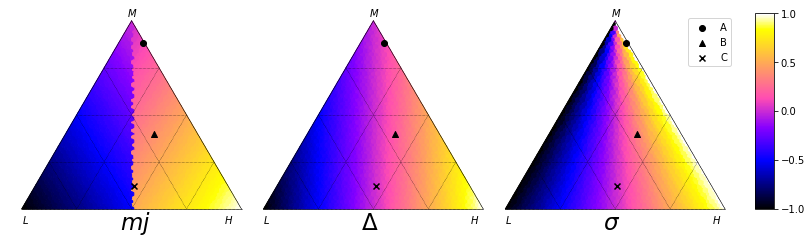

In [310]:
col = 'gnuplot2' # gnuplot2 jet RdYlGn
key = 'HML'
fig = ternary_vote(col, scale = 50, value = ('$H$', '$M$', '$L$'))
_ = fig.savefig('ternary plots/'+col+' '+key+'.png', dpi=200)

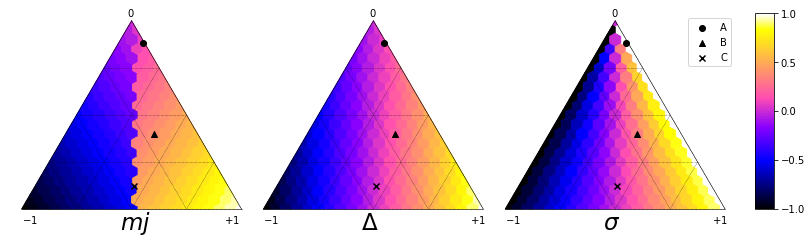

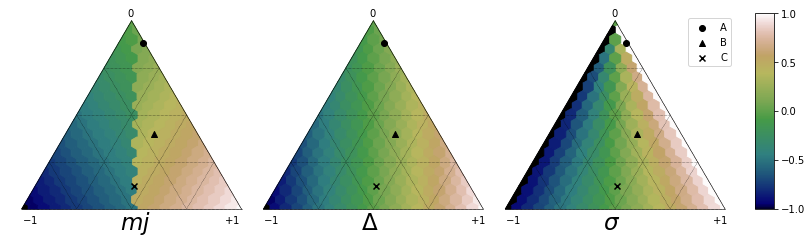

In [20]:
ternary_vote(col = 'gnuplot2', scale = 20)
ternary_vote(col = 'gist_earth', scale = 20)

angles = {'HML': ('$H$', '$M$', '$L$'), '+0-': ('$+1$', '$0$', '$-1$'), 'prq': ('$p$', '$r$', '$q$')} # '$1-p-q$'
matplotlib.rcParams.update({'font.size': 15})
scale = 4
colors = 'viridis' # 'RdYlGn' 'jet'
style = 'h' # t d ou h

for key, value in angles.items():
#     H, M, L =  value
    for col in ['viridis', 'RdYlGn']:
        colors = col
        for shape in ['h', 'd', 't']:
            style = shape
#             ternary_vote(colors, style, value)
#             _ = fig.savefig('ternary plots/'+shape+' '+col+' '+key+'.png', dpi=200)

## Deprecated

In [ ]:
# ### Useless

# figure, MJ = ternary.figure(scale=scale)
# MJ.heatmapf(mj, boundary=True, style="triangular")
# MJ.boundary(linewidth=0.5)
# MJ.set_title("mj")

# MJ.show()

# def heatmap(data, scale, vmin=None, vmax=None, cmap=None, ax=None,
#             scientific=False, style='triangular', colorbar=True,
#             permutation=None, use_rgba=False, cbarlabel=None, cb_kwargs=None, contour=True):
#     """
#     Plots heatmap of given color values.
#     Parameters
#     ----------
#     data: dictionary
#         A dictionary mapping the i, j polygon to the heatmap color, where
#         i + j + k = scale.
#     scale: Integer
#         The scale used to partition the simplex.
#     vmin: float, None
#         The minimum color value, used to normalize colors. Computed if absent.
#     vmax: float, None
#         The maximum color value, used to normalize colors. Computed if absent.
#     cmap: String or matplotlib.colors.Colormap, None
#         The name of the Matplotlib colormap to use.
#     ax: Matplotlib AxesSubplot, None
#         The subplot to draw on.
#     scientific: Bool, False
#         Whether to use scientific notation for colorbar numbers.
#     style: String, "triangular"
#         The style of the heatmap, "triangular", "dual-triangular" or "hexagonal"
#     colorbar: bool, True
#         Show colorbar.
#     permutation: string, None
#         A permutation of the coordinates
#     use_rgba: bool, False
#         Use rgba color values
#     cbarlabel: string, None
#         Text label for the colorbar
#     cb_kwargs: dict
#         dict of kwargs to pass to colorbar
#     Returns
#     -------
#     ax: The matplotlib axis
#     """

#     if not ax:
#         fig, ax = pyplot.subplots()
#     # If use_rgba, make the RGBA values numpy arrays so that they can
#     # be averaged.
#     if use_rgba:
#         for k, v in data.items():
#             data[k] = numpy.array(v)
#     else:
#         cmap = get_cmap(cmap)
#         if vmin is None:
#             vmin = min(data.values())
#         if vmax is None:
#             vmax = max(data.values())
#     style = style.lower()[0]
#     if style not in ["t", "h", 'd']:
#         raise ValueError("Heatmap style must be 'triangular', 'dual-triangular', or 'hexagonal'")

#     vertices_values = polygon_generator(data, scale, style,
#                                         permutation=permutation)

#     # Draw the polygons and color them
#     for vertices, value in vertices_values:
#         if value is None:
#             continue
#         if not use_rgba:
#             color = colormapper(value, vmin, vmax, cmap=cmap)
#         else:
#             color = value  # rgba tuple (r,g,b,a) all in [0,1]
#         # Matplotlib wants a list of xs and a list of ys
#         xs, ys = unzip(vertices)
#         ax.fill(xs, ys, facecolor=color, edgecolor=color)

#     if not cb_kwargs:
#         cb_kwargs = dict()
#     if colorbar:
#         colorbar_hack(ax, vmin, vmax, cmap, scientific=scientific,
#                       cbarlabel=cbarlabel, **cb_kwargs)
#     return ax

# ## User Convenience Functions
# def heatmapf(func, scale=10, boundary=True, cmap=None, ax=None,
#              scientific=False, style='triangular', colorbar=True,
#              permutation=None, vmin=None, vmax=None, cbarlabel=None,
#              cb_kwargs=None, contour = True):
#     """
#     Computes func on heatmap partition coordinates and plots heatmap. In other
#     words, computes the function on lattice points of the simplex (normalized
#     points) and creates a heatmap from the values.
#     Parameters
#     ----------
#     func: Function
#         A function of 3-tuples to be heatmapped
#     scale: Integer
#         The scale used to partition the simplex
#     boundary: Bool, True
#         Include the boundary points or not
#     cmap: String, None
#         The name of the Matplotlib colormap to use
#     ax: Matplotlib axis object, None
#         The axis to draw the colormap on
#     style: String, "triangular"
#         The style of the heatmap, "triangular", "dual-triangular" or "hexagonal"
#     scientific: Bool, False
#         Whether to use scientific notation for colorbar numbers.
#     colorbar: bool, True
#         Show colorbar.
#     permutation: string, None
#         A permutation of the coordinates
#     vmin: float
#         The minimum color value, used to normalize colors.
#     vmax: float
#         The maximum color value, used to normalize colors.
#     cb_kwargs: dict
#         dict of kwargs to pass to colorbar
#     Returns
#     -------
#     ax, The matplotlib axis
#     """

#     # Apply the function to a simplex partition
#     data = dict()
#     for i, j, k in simplex_iterator(scale=scale, boundary=boundary):
#         data[(i, j)] = func(normalize([i, j, k]))
#     # Pass everything to the heatmapper
#     ax = heatmap(data, scale, cmap=cmap, ax=ax, style=style,
#                  scientific=scientific, colorbar=colorbar,
#                  permutation=permutation, vmin=vmin, vmax=vmax, 
#                  cbarlabel=cbarlabel, cb_kwargs=cb_kwargs, contour=contour)
#     return ax

# https://stackoverflow.com/questions/51104595/how-to-make-a-ternary-contour-plot-with-python-plotly
# https://rdrr.io/cran/qualityTools/man/contourPlot3.html
# https://stackoverflow.com/questions/10879361/ternary-plot-and-filled-contour
# https://matplotlib.org/gallery/images_contours_and_fields/contourf_log.html#sphx-glr-gallery-images-contours-and-fields-contourf-log-py
# https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.contourf.html
# https://community.plot.ly/t/error-displaying-figurewidget/11974/14
    
# import numpy as np
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# #Always run this the command before at the start of notebook
# init_notebook_mode(connected=True)
# import plotly.graph_objs as go

# import platform
# import plotly
# import plotly.plotly as py

# import plotly.graph_objs as go
# import numpy as np
# from scipy.interpolate import griddata

# A = np.array([0, .3 ,.25, .34 ,0, .4 ,.65, 0.05,  0,  1, .47, .2, .7])  #pos 10 1, 0, 0
# B = np.array([1, .1, .45, .56, 0, .5, .3,  0.75, .85, 0,  .33, .3, .13])
# C = np.array([0, .6 ,.3,  .1,  1, .1, .05,  .2,  .15, 0,  .2,  .5, .17])

# pl_ternary=dict(type='scatterternary', a=A, b=B, c=C, mode='markers',  marker=dict(size=10, color='red'))

# layout=dict(width=500, height=400, ternary= {'sum':1,
#                       'aaxis':{'title': '0',  'min': 0.001, 'linewidth':0.5, 'ticks':'outside' },
#                       'baxis':{'title': '-1',  'min': 0.001, 'linewidth':0.5, 'ticks':'outside' },
#                       'caxis':{'title': '+1',  'min': 0.001, 'linewidth':0.5, 'ticks':'outside' }}, showlegend= False)

# fw=go.FigureWidget(data=[pl_ternary], layout=layout)
# fw

# def tr_b2c2b():
#     # returns the transformation matrix from barycentric to cartesian coordinates and conversely
#     tri_verts = np.array([[0.5, np.sqrt(3)/2], [0, 0], [1, 0]])# reference triangle
#     M = np.array([tri_verts[:,0], tri_verts[:, 1], np.ones(3)]) 
#     return M, np.linalg.inv(M) 

# z=np.array([1.27, 1.27, 0.52255697, 1.50035059, 0.84853798, 1.2, 1.2092, 0.88, 0.59, 0.9223051, 1.57173859, 1.33606612, 1.08977333])
# z=np.array([1., 1., 1., 1., 1., 1.2, 1., 1., 1., 1., 1., 1., 1.])

# def contour_trace(x, y, z, tooltip, colorscale='Viridis', reversescale=False,  linewidth=0.5, linecolor='rgb(150,150,150)'):
#     return  dict(type='contour', x=x, y=y, z=z,text=tooltip, hoverinfo='text',    
#                  colorscale=colorscale, reversescale=reversescale, line=dict(width=linewidth, color=linecolor), colorbar=dict(thickness=20, ticklen=4))

# def barycentric_ticks(side):
#     # side 0, 1 or  2; side j has 0 in the  j^th position of barycentric coords of tick origin
#     # returns the list of tick origin barycentric coords
#     p = 10
#     if side == 0: return np.array([(0, j/p, 1-j/p) for j in range(p-2, 0, -2)]) #where a=0        
#     elif side == 1: return np.array([(i/p, 0, 1-i/p)  for i in  range( 2, p, 2) ]) # b=0        
#     elif side == 2: return np.array([(i/p, j/p, 0)  for i in range(p-2, 0, -2) for j in range(p-i, -1, -1)  if i+j==p]) #c=0        
#     else: raise ValueError('The side can be only 0, 1, 2')

# def cart_coord_ticks(side, t=0.01):
#     # side 0, 1 or 2
#     # each tick segment is parameterized as (x(s), y(s)), s in [0, t]
#     global  M, xt, yt, posx, posy
#     # M is the transformation matrix from barycentric to cartesian coords
#     # xt, yt are the lists of x, resp y-coords of tick segments
#     # posx, posy are the lists of ticklabel positions for side 0, 1, 2 (concatenated)
    
#     baryc = barycentric_ticks(side)
#     xy1 = np.dot(M, baryc.T)
#     xs, ys = xy1[:2] 
#     if side == 0:
#         for i in range(4):
#             xt.extend([xs[i], xs[i]+t, None])
#             yt.extend([ys[i], ys[i]-np.sqrt(3)*t, None])
#         posx.extend([xs[i]+t for i in range(4)])
#         posy.extend([ys[i]-np.sqrt(3)*t for i in range(4)])        
#     elif  side == 1:
#         for i in range(4):
#             xt.extend([xs[i], xs[i]+t, None])
#             yt.extend([ys[i], ys[i]+np.sqrt(3)*t, None])
#         posx.extend([xs[i]+t for i in range(4)]) 
#         posy.extend([ys[i]+np.sqrt(3)*t for i in range(4)])        
#     elif side == 2:
#         for i in range(4):
#             xt.extend([xs[i], xs[i]-2*t, None])
#             yt.extend([ys[i], ys[i], None])
#         posx.extend([xs[i]-2*t for i in range(4)])
#         posy.extend([ys[i] for i in range(4)]) 
#     else: raise ValueError('side can be only 0,1,2')
        
# def ternary_layout(title='', width=550, height=525,  fontfamily= 'Balto, sans-serif' , lfontsize=14, plot_bgcolor='rgb(240,240,240)',
#                    vertex_text=['a', 'b', 'c'], v_fontsize=14):

#      return dict(title=title, font=dict(family=fontfamily, size=lfontsize), width=width, height=height, xaxis=dict(visible=False),
#                  yaxis=dict(visible=False), plot_bgcolor=plot_bgcolor, showlegend=False,
#                  #annotations for strings  placed at the triangle vertices
#                  annotations=[dict(showarrow=False,
#                                    text=vertex_text[0], x=0.5, y=np.sqrt(3)/2, align='center', xanchor='center', yanchor='bottom', font=dict(size=v_fontsize)),
#                               dict(showarrow=False, text=vertex_text[1], x=0, y=0, align='left',xanchor='right', yanchor='top', font=dict(size=v_fontsize)),
#                               dict(showarrow=False, text=vertex_text[2], x=1, y=0, align='right', xanchor='left', yanchor='top', font=dict(size=v_fontsize))
#                               ],
                
# #     shapes=[
# #         # unfilled Rectangle
# #         {
# #             'type': 'triangle',
# #             'x0': 0,
# #             'y0': 0,
# #             'x1': 0,
# #             'y1': 1,
# #             'x2': 0.5,
# #             'y2': 1,
# #             'line': {
# #                 'color': 'rgba(128, 0, 128, 1)',
# #             },
# #         },
# #         # filled Rectangle
# #         {
# #             'type': 'rect',
# #             'x0': 1,
# #             'y0': 1,
# #             'x1': 1,
# #             'y1': 1,
# #             'x2': 0.5,
# #             'y2': 1,
# #             'fillcolor': 'rgba(128, 0, 128, 0.7)',
# #         },
# #     ]
#                 )

# def set_ticklabels(annotations, posx, posy, proportion=True):
#     #annotations: list of annotations previously defined in layout definition as a dict,
#     #     not as an instance of go.Layout
#     #posx, posy:  lists containing ticklabel position coordinates
#     #proportion - boolean; True when ticklabels are 0.2, 0.4, ... False when they are 20%, 40%...

#     if not isinstance(annotations, list):
#         raise ValueError('annotations should be a list')

#     ticklabel = [0.8, 0.6, 0.4, 0.2] if proportion else ['80%', '60%', '40%', '20%'] 

#     annotations.extend([dict(showarrow=False, # annotations for ticklabels on side 0
#                              text=ticklabel[j], x=posx[j], y=posy[j], align='center', xanchor='center', yanchor='top', font=dict(size=12)) for j in range(4)])

#     annotations.extend([dict(showarrow=False, # annotations for ticklabels on  side 1
#                              text=ticklabel[j], x=posx[j+4], y=posy[j+4], align='center', xanchor='left',  yanchor='middle', font=dict(size=12)) for j in range(4)])

#     annotations.extend([dict(showarrow=False, # annotations for ticklabels on side 2
#                              text=ticklabel[j], x=posx[j+8], y=posy[j+8], align='center',xanchor='right',  yanchor='middle', font=dict(size=12)) for j in range(4)])
#     return annotations

# def styling_traces():
#     global xt, yt
#     side_trace = dict(type='scatter', x=[0.5, 0, 1, 0.5], y=[np.sqrt(3)/2, 0, 0, np.sqrt(3)/2], mode='lines', line=dict(width=2, color='#444444'), hoverinfo='none')
    
#     tick_trace = dict(type='scatter',  x=xt, y=yt, mode='lines', line=dict(width=1, color='#444444'), hoverinfo='none')
    
#     return side_trace, tick_trace


# M, invM =  tr_b2c2b()
# cartes_coord_points = np.einsum('ik, kj -> ij', M, np.stack((A, B, C)))
# xx, yy = cartes_coord_points[:2]
# a, b = xx.min(), xx.max()
# c, d = yy.min(), yy.max()
# N=10
# gr_x = np.linspace(a,b, N)
# gr_y = np.linspace(c,d, N)
# grid_x, grid_y = np.meshgrid(gr_x, gr_y)

# # tern2cart <- function(coord){
# #     coord[1]->x
# #     coord[2]->y
# #     coord[3]->z
# #     x+y+z -> tot
# #     x/tot -> x  # First normalize the values of x, y and z
# #     y/tot -> y
# #     z/tot -> z
# #     (2*y + z)/(2*(x+y+z)) -> x1 # Then transform into cartesian coordinates
# #     sqrt(3)*z/(2*(x+y+z)) -> y1
# #     return(c(x1,y1))
# #     }

# from ternary.helpers import unzip, normalize, simplex_iterator, project_point
# from ternary.heatmapping import hexagon_coordinates

# func = jm
# data = dict()
# for i, j, k in simplex_iterator(scale=N, boundary=True):
#     data[(i, j)] = func(normalize([i, j, k]))

# project = functools.partial(project_point, permutation=None)
# for key, value in data:
#     if value is None:
#         continue
#     i = key[0]
#     j = key[1]
#     k = N - i - j
#     vertices = hexagon_coordinates(i, j, k)
#     yield (map(project, vertices), value)
# project_point(hexagon_coordinates(3, 3, 4), permutation=None)
        
# #interpolate data (cartes_coords[:2].T; z)  and evaluate the  interpolatory function at the meshgrid points to get grid_z
# grid_z = griddata(cartes_coord_points[:2].T, z, (grid_x, grid_y), method='cubic')
# bar_coords = np.einsum('ik, kmn -> imn', invM, np.stack((grid_x, grid_y, np.ones(grid_x.shape))))
# bar_coords[np.where(bar_coords<0)] = None # invalidate the points outside of the reference triangle
# xy1 = np.einsum('ik, kmn -> imn', M, bar_coords) # recompute back the cartesian coordinates of bar_coords with invalid positions
#                                                # and extract indices where x are nan

# I = np.where(np.isnan(xy1[0]))
# grid_z[I] = None
# # tooltips for  proportions, i.e. a+b+c=1

# # t_proportions = [['a: {round(bar_coords[0][i,j], 2)}<br>b: {round(bar_coords[1][i,j], 2)}'+\
# #                   '<br>c: {round(1-round(bar_coords[0][i,j], 2)-round(bar_coords[1][i,j], 2), 2)}'+\
# #                   '<br>z: {round(grid_z[i,j],2)}'  if ~np.isnan(xy1[0][i,j]) else '' for j in range(N)]
# #                                        for i in range(N)] 

# # tooltips for  percents, i.e. a+b+c=100
# # t_percents=[['a: {int(100*bar_coords[0][i,j]+0.5)}<br>b: {int(100*bar_coords[1][i,j]+0.5)}'+\
# #              '<br>c: {100-int(100*bar_coords[0][i,j]+0.5)-int(100*bar_coords[1][i,j]+0.5)}'+\
# #              '<br>z: {round(grid_z[i,j],2)}'  if ~np.isnan(xy1[0][i,j]) else '' for j in range(N)] 
# #                                          for i in range(N)] 
# pl_deep = [[0.0, 'rgb(253, 253, 204)'],
#            [0.1, 'rgb(201, 235, 177)'],
#            [0.2, 'rgb(145, 216, 163)'],
#            [0.3, 'rgb(102, 194, 163)'],
#            [0.4, 'rgb(81, 168, 162)'],
#            [0.5, 'rgb(72, 141, 157)'],
#            [0.6, 'rgb(64, 117, 152)'],
#            [0.7, 'rgb(61, 90, 146)'],
#            [0.8, 'rgb(65, 64, 123)'],
#            [0.9, 'rgb(55, 44, 80)'],
#            [1.0, 'rgb(39, 26, 44)']]
# xt = []
# yt = []
# posx = []
# posy = []
# for side in [0, 1, 2]:
#     cart_coord_ticks(side, t=0.01)

# # colorscale
# pl_deep = [[0.0, 'rgb(253, 253, 204)'],
#            [0.1, 'rgb(201, 235, 177)'],
#            [0.2, 'rgb(145, 216, 163)'],
#            [0.3, 'rgb(102, 194, 163)'],
#            [0.4, 'rgb(81, 168, 162)'],
#            [0.5, 'rgb(72, 141, 157)'],
#            [0.6, 'rgb(64, 117, 152)'],
#            [0.7, 'rgb(61, 90, 146)'],
#            [0.8, 'rgb(65, 64, 123)'],
#            [0.9, 'rgb(55, 44, 80)'],
#            [1.0, 'rgb(39, 26, 44)']]

# # tooltip = t_proportions
# layout = ternary_layout()
# # ticklabels
# # annotations = set_ticklabels(layout['annotations'], posx, posy, proportion=True)

# c_trace = dict(type='contour', x=gr_x, y=gr_y, z=z, text=None, hoverinfo='',    
#                  colorscale=pl_deep, reversescale=True, line=dict(width=0.5, color='rgb(150,150,150)'), colorbar=dict(thickness=20, ticklen=4)
#     #contour_trace(gr_x, gr_y, grid_z, None, colorscale=pl_deep, reversescale=True)
# side_trace = dict(type='scatter', x=[0.5, 0, 1, 0.5], y=[np.sqrt(3)/2, 0, 0, np.sqrt(3)/2], mode='lines', fill = 'tonext',
#                   line=dict(width=2, color='#444444'), hoverinfo='none')
# fw1 = go.FigureWidget(data=[c_trace,  side_trace], layout=layout) # tick_trace, 
# # fw1.layout.annotations=annotations
    
# fw1
# # import plotly.plotly as py
# # py.sign_in('empet', 'api_key')
# # py.iplot(fw1, filename='ternary1_cont') 

# def ds(vec, scale=0.2):
#     p, r, q = vec
#     if (scale): return(np.tanh(scale*(p-q)/(1-p-q-1e-7)))
#     else: return((p-q)/(1-p-q-1e-7))
    
# def Ds(vec, scale=None):
#     p, r, q = vec
#     f = (p - q)/(1-min(p, 0.5)-min(q, 0.5)-1e-7)
#     if (scale): return(np.tanh(scale*f))
#     else: return(f)   